## 標本影響関数（SIF: Sample Influence Function）による身長座高データの異常検知

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
 
height = pd.read_csv("/Users/ShuntaroMiwa/00 python/fueda/assignment.csv")#,encoding="SHIFT-JIS")
height.head()

,身長,座高
0,159,88
1,150,84
2,157,86
3,153,81
4,158,83


In [46]:
stats.shapiro(height["身長"])

ShapiroResult(statistic=0.965831995010376, pvalue=0.6655755639076233)

In [47]:
stats.shapiro(height["座高"])

ShapiroResult(statistic=0.8940091729164124, pvalue=0.031887732446193695)

### シャピロ・ウィルク検定の帰無仮説は「正規分布である」であり、座高は帰無仮設が5%水準で棄却されたことにより、正規分布ではないことが示唆された。
### →χ2分布で近似し、閾値を設定する。

In [50]:
#閾値の設定
#https://qiita.com/MasafumiTsuyuki/items/2677576849abf633e412

from scipy.stats import chi2

m = 2    # 自由度 (特徴量の次元) を設定
p = 0.05  # 異常検知される確率を設定
threshold = chi2.isf(p, m)  # 異常検知の閾値を計算
print(threshold)

5.991464547107983


### 回帰式の作成

In [2]:
# sklearn.linear_model.LinearRegression クラスを読み込み
from sklearn import linear_model
clf = linear_model.LinearRegression()

#https://medium.com/@yamasaKit/scikit-learn%E3%81%A7%E5%8D%98%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%E3%82%92%E8%A1%8C%E3%81%86%E6%96%B9%E6%B3%95-f6baa2cb761e
# 説明変数に "身長" を利用
X = height['身長'].to_frame()#.as_matrix()

# 目的変数に "座高" を利用
Y = height['座高'].to_frame()#.as_matrix()
 
# 予測モデルを作成
clf.fit(X, Y)
 
# 回帰係数
coef_20= clf.coef_
print(clf.coef_)
 
# 切片 (誤差)
intr_20= clf.intercept_
print(clf.intercept_)
 
# 決定係数
print(clf.score(X, Y))

[[0.47565492]]
[10.38266356]
0.5603163220885783


In [3]:
print(type(clf.coef_))

<class 'numpy.ndarray'>


In [4]:
print(X[X.index !=1])

     身長
0   159
2   157
3   153
4   158
5   152
6   155
7   157
8   145
9   158
10  161
11  150
12  148
13  154
14  154
15  159
16  149
17  155
18  153
19  160


### SIFの算出

In [5]:
sif_coef=[]
sif_intr=[]

for i in range(len(height.index)):
    clf.fit(X[X.index != i], Y[Y.index != i])
    sif_c = (len(height.index)-1)*(coef_20-clf.coef_)#19×回帰係数の差（２０サンプルー19サンプル）
    sif_c = sif_c.flatten()
    sif_coef.append(sif_c[0])
    sif_i =  (len(height.index)-1)*(intr_20-clf.intercept_)#19×切片の差（２０サンプルー19サンプル）
    sif_intr.append(sif_i[0])


In [6]:
cols = ['coef', 'intr']
sif = pd.DataFrame(index=[], columns=cols)

In [7]:
sif['coef'] = sif_coef
sif['intr'] = sif_intr
sif[:20]

,coef,intr
0,0.540985,-81.380455
1,-0.572819,90.814896
2,0.139418,-20.560221
3,0.160665,-26.967999
4,-0.528172,78.885773
5,-0.303666,49.226153
6,-0.039602,5.002033
7,-0.305763,45.091415
8,2.300479,-359.563691
9,-0.111656,16.676463


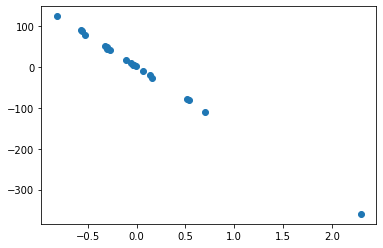

In [25]:
plt.scatter(sif_coef, sif_intr)

## マハラノビス距離の算出（MT法）
### マハラノビス距離を算出し、閾値を超えたものを異常値とする。

### https://qiita.com/shinmura0/items/901593e3d8a5238f8ae4

In [9]:
sif_nd = np.array(sif)
print(sif_nd)

[[ 5.40985154e-01 -8.13804549e+01]
 [-5.72819252e-01  9.08148959e+01]
 [ 1.39418077e-01 -2.05602206e+01]
 [ 1.60665484e-01 -2.69679991e+01]
 [-5.28172192e-01  7.88857728e+01]
 [-3.03665732e-01  4.92261534e+01]
 [-3.96019654e-02  5.00203287e+00]
 [-3.05763178e-01  4.50914151e+01]
 [ 2.30047934e+00 -3.59563691e+02]
 [-1.11655676e-01  1.66764635e+01]
 [-8.21047143e-01  1.24478155e+02]
 [-3.20375758e-01  5.07924463e+01]
 [ 7.01659110e-01 -1.10315177e+02]
 [-7.03953443e-03  1.45316104e+00]
 [-2.62480844e-02  5.41835457e+00]
 [-2.75306808e-01  4.14144327e+01]
 [-5.58244332e-01  8.80669564e+01]
 [ 6.75099166e-02 -8.52702177e+00]
 [-6.27017145e-02  1.05245989e+01]
 [ 5.16451057e-01 -7.80480947e+01]]


In [67]:
xx = np.copy(sif_nd)
avg = np.zeros(2)

#各特徴量から平均値を引く（差分）
for i in range(2):
    avg[i] = np.mean(sif_nd[:,i])#列に対しての平均（２列、係数と切片）
    for j in range(len(sif_nd)):
        xx[j,i] = sif_nd[j,i] - avg[i]#特徴量から平均を引く

In [68]:
avg[0:5]

array([ 0.02472634, -3.87589105])

In [69]:
xx[0:5]

array([[  0.51625882, -77.50456387],
       [ -0.59754559,  94.69078698],
       [  0.11469174, -16.68432953],
       [  0.13593915, -23.09210803],
       [ -0.55289853,  82.76166381]])

In [70]:
std = np.zeros(2)

#特徴量と平均値の差分を標準偏差で割る
for i in range(2):
    std[i] = np.std(sif_nd[:,i], ddof=1)#列に対しての不偏標準偏差（２列、係数と切片）
    for j in range(len(sif_nd)):
        xx[j,i] = xx[j,i] / std[i]##差分を標準偏差で割る

In [71]:
std[0:2]

array([  0.66321325, 103.1120431 ])

In [72]:
xx.shape

(20, 2)

In [73]:
R = np.corrcoef(sif_nd.transpose())#相関係数（分散共分散行列。関数の都合上、sif_ndを横長にしている）
invR = np.linalg.inv(R)#相関係数の逆行列

In [74]:
print(invR)

[[2922.23482022 2921.73477743]
 [2921.73477743 2922.23482022]]


In [75]:
print(R)#各状態量は非常に相関が高い

[[ 1.         -0.99982888]
 [-0.99982888  1.        ]]


In [76]:
xx[0,:]

array([ 0.77842053, -0.75165385])

In [77]:
print(np.dot(xx[0,:],invR))

[78.59440279 77.82930014]


In [115]:
#マハラノビス距離の算出
x_return = []
for i in range(len(sif_nd)):
        d0 = xx[i,:]#各行の値(要素数2の横ベクトル)
        d1 = np.dot(d0,invR)
        d2 = np.dot(d1,d0)/2#ベクトルの内積なので転置不要／自由度で割っている
        x_return.append(d2)

In [79]:
x_return[0:20]

[1.339402051011085,
 0.8532344846457178,
 0.194849598303398,
 0.5493693317338506,
 1.7412748852695046,
 0.702677162263381,
 0.17761606859750678,
 0.9198511494863268,
 6.398743031947305,
 0.0788128681393101,
 2.1498422243313655,
 0.2792879429509556,
 0.7228473846896684,
 0.02217263964292593,
 0.26105013644254593,
 0.35237111132844845,
 0.6264695964740348,
 0.551474182485131,
 0.09887051552368153,
 0.9797836347280935]

### カイ２乗分布による閾値5.99を超えるのは九番目のデータであり、削除の後に再度異常検出

In [130]:
height=height.drop(height.index[[8]])

In [131]:
height[:20]

,身長,座高
0,159,88
1,150,84
2,157,86
3,153,81
4,158,83
5,152,85
6,155,83
7,157,83
9,158,85
10,161,85


In [132]:
stats.shapiro(height["身長"])

ShapiroResult(statistic=0.9593928456306458, pvalue=0.5604773163795471)

In [133]:
stats.shapiro(height["座高"])

ShapiroResult(statistic=0.9392363429069519, pvalue=0.2554613947868347)

### シャピロ・ウィルク検定の帰無仮説は「正規分布である」であり、身長・座高どちらも帰無仮説が5%水準で棄却されないため、多変量正規分布である。
### →F分布（2, 17）に従う

In [134]:
height.shape

(19, 2)

In [135]:
from scipy.stats import f

# 分子、分母の自由度
dfn, dfd = 2, 17

# 5%点の値(上側なので、95% を指定する)
five = f.ppf(0.95, dfn, dfd)
print('上側確率 5%:', five)

# # 1%点の値(上側なので、99% を指定する)
# one = f.ppf(0.99, dfn, dfd)
# print('上側確率 1%:', one)

上側確率 5%: 3.5915305684750827


### F分布（2, 17）上側5%水準による閾値は3.59

In [136]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

#https://medium.com/@yamasaKit/scikit-learn%E3%81%A7%E5%8D%98%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%E3%82%92%E8%A1%8C%E3%81%86%E6%96%B9%E6%B3%95-f6baa2cb761e
# 説明変数に "身長" を利用
X = height['身長'].to_frame()#.as_matrix()

# 目的変数に "座高" を利用
Y = height['座高'].to_frame()#.as_matrix()
 
# 予測モデルを作成
clf.fit(X, Y)
 
# 回帰係数
coef_20= clf.coef_
print(clf.coef_)
 
# 切片 (誤差)
intr_20= clf.intercept_
print(clf.intercept_)
 
# 決定係数
print(clf.score(X, Y))

[[0.35457706]]
[29.30706837]
0.41202751661117387


### SIF

In [137]:
sif_coef=[]
sif_intr=[]

for i in range(len(height.index)):
    clf.fit(X[X.index != i], Y[Y.index != i])
    sif_c = (len(height.index)-1)*(coef_20-clf.coef_)#18×回帰係数の差
    sif_c = sif_c.flatten()
    sif_coef.append(sif_c[0])
    sif_i =  (len(height.index)-1)*(intr_20-clf.intercept_)#18×切片の差
    sif_intr.append(sif_i[0])

In [138]:
cols = ['coef', 'intr']
sif = pd.DataFrame(index=[], columns=cols)
sif['coef'] = sif_coef
sif['intr'] = sif_intr
sif[:20]

,coef,intr
0,0.719289,-108.894880
1,-0.559317,88.262657
2,0.156935,-23.257075
3,0.332810,-54.124494
4,-0.533644,80.206620
5,-0.367613,58.777231
6,-0.013943,0.892368
7,-0.302687,44.856689
8,0.000000,0.000000
9,-0.075628,11.366925


### マハラノビス距離

In [139]:
sif_nd = np.array(sif)

In [140]:
xx = np.copy(sif_nd)
avg = np.zeros(2)

#各状態量から平均値を引く
for i in range(2):
    avg[i] = np.mean(sif_nd[:,i])
    for j in range(len(sif_nd)):
        xx[j,i] = sif_nd[j,i] - avg[i]

In [141]:
std = np.zeros(2)

#標準偏差で割る
for i in range(2):
    std[i] = np.std(sif_nd[:,i], ddof=1)
    for j in range(len(sif_nd)):
        xx[j,i] = xx[j,i] / std[i]

In [142]:
R = np.corrcoef(sif_nd.transpose())
invR = np.linalg.inv(R)

In [143]:
x_return = []
for i in range(len(sif_nd)):
        d0 = xx[i,:]
        d1 = np.dot(d0,invR)
        d2 = np.dot(d1,d0)*2/17#自由度の係数
        x_return.append(d2)

In [144]:
x_return[0:20]

[0.6715744172267832,
 0.2063400011104335,
 0.08906723689977938,
 0.26602122130467915,
 0.4100452126086693,
 0.17942545881725927,
 0.054148902836676956,
 0.21577720847864115,
 0.0014942840443449618,
 0.0033278829163219635,
 0.3630613393439366,
 0.024670099622721885,
 1.387642682336103,
 0.0027700303951305413,
 0.061882211622087104,
 0.03700760525833262,
 0.09160503139441378,
 0.15572441547240276,
 0.013708875961492936]

### F検定（2,17）上側確率5%水準による閾値3.59を超えるものはなく、異常値は検出されなかった。